In [351]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Create Dataframe

In [352]:
main_folder_path = r"C:\Users\blake\OneDrive\Desktop\WorkoutData\iCloud Notes\Workouts"

In [353]:
# List to store file content
data = []

# Traverse through all subfolders and text files
for root, dirs, files in os.walk(main_folder_path):
    for file in files:
        if file.endswith('.txt'):  # Ensure it only reads text files
            file_path = os.path.join(root, file)
            
            # Read the content of the text file
            with open(file_path, 'r',encoding="utf8") as f:
                content = f.readlines()

            folder_name = os.path.basename(root)
            file_name = file
            data.append({'Folder': folder_name, 'File': file_name, 'Content': content})

# Convert list to DataFrame
df = pd.DataFrame(data)

# Extract date/times and sort
df['Extract'] = df['File'].apply(lambda x: x[-24:-5].replace('_',':'))
df['Date'] = pd.to_datetime(df['Extract'])
df = df.sort_values('Date')


### DATA CLEANING

# Remove first three entries
df = df.iloc[3:]

# Remove routine notes
df = df.drop([380,276,295,48])

In [354]:
### Things to try
exercises = ["Squat","Bench","Dead","Skull","Overhead press"]
for i in exercises:
    df[i] = 0
    df[i+'_ORM']=0
df['NONE'] = False

In [355]:
### Fill the lift binaries. REMOVE LATER?
for index, row in df.iterrows():
    lift = False
    for line in row['Content']:
        for m in exercises:
            if m in line:
                df.at[index,m] = 1
                lift = True
    df.at[index,'NONE'] = lift

# Calculate one repetition maximum (ORM) for each lift

In [356]:
import re
"""Return: both the weight and reps as integers from single string"""
def extract_weight_reps(line):
    '''
    TEST CASES:
    
    >>> extract_weight_reps("135x5")
    (135, 5)
    
    >>> extract_weight_reps("135 x 5")
    (135, 5)
    
    >>> extract_weight_reps("135x5.75")
    (135, 6)
    
    >>> extract_weight_reps("44.75x5")
    (45, 5)
    
    >>> extract_weight_reps("175x7 (last time 165x8)")
    (175, 7)
    
    >>> extract_weight_reps("185x2 F on 3")
    (185, 2)
    
    >>> extract_weight_reps("SS 25x7")
    (25, 7)
    
    >>> extract_weight_reps("70x2+ 45x2 Yikes")
    (70, 2)
    
    >>> extract_weight_reps("120x5 - 90x4")
    (120, 5)
    
    >>> extract_weight_reps("120x5 - 90x4 - 30x5")
    (120, 5)
    
    >>> extract_weight_reps("135x2.5 (not full 3rd)")
    (135, 2)
    
    >>> extract_weight_reps("200x1 (fail on 2)")
    (200, 1)
    
    >>> extract_weight_reps("5 set 95")
    (0, 0)
    
    
    >>> extract_weight_reps("205 x F")
    (0, 0)
    
    '''
    weight = 135
    reps = 5
    
    split = line.split('x')
    
    # no 'x' case
    if len(split) == 1:
        return 0, 0
    
    # simple case (should handle dropsets too?)
    if len(split) > 1:
        a = split[0].strip()
        b = split[1].strip()
        w = re.findall(r"[\d,.]{1,}$",a)
        r = re.findall(r"^[\d,.]{1,}",b)
        
        if len(w) == 0 or len(r) == 0:
            return 0, 0
        
        weight = round(float(w[0]))
        reps = round(float(r[0]))
    return weight, reps

In [357]:
### TESTING
import doctest
doctest.testmod(verbose=False)

TestResults(failed=0, attempted=14)

In [358]:
def get_clean(lift,content):
    """Return: list of sets for particular lift. 
    Returns None if no sets were done for that lift"""
    start_index = None
    end_index = None
    for i, item in enumerate(content):
        if lift in item:
            print(lift)
            start_index = i
        
        elif item == "\n" and start_index != None and i != start_index + 1:
            
            ## check to make sure it's not a linebreak after a comment at start of lift
            if not re.search(r'\dx\d',content[i-1]):
                continue
                
            end_index = i
            break
            
    ## handle not finding lift
    if start_index == None:
        return None
    ## removes front/back whitespaces, 
    clean = [i.strip() for i in content[start_index+1:end_index]]
    return clean

In [359]:
def find_ORM(lift, content):
    """Return: the highest ORM for a certain lift within a certain workout's contents"""
    
    print(f'FIND {lift} ORM FOR..........')
    print(content)
    
    #extract sets done for a lift
    clean = get_clean(lift,content)
    
    ## handle not finding any sets
    if clean == None:
        return None
    
    print(f"clean: {clean}")
    
    ## formula: weight × (36 / (37 - reps))
    top = 0
    for i in clean:
        weight, reps = extract_weight_reps(i)
        ORM = weight * (36/(37 - reps))
        print(f"{ORM} = {weight}*{reps}")
        if ORM > top:
            top = ORM
    print(f"ORM ======= {top}")
    return top
    

In [360]:
### fill the ORMs

for index, row in df.iterrows():
    for i in exercises:
        ORM = find_ORM(i, row['Content'])
        setit = i + '_ORM'
        df.at[index,setit] = ORM

FIND Squat ORM FOR..........
['Fullcatalog 2/4\n', 'Friday 7:35 no line\n', '\n', 'Squat\n', '\n', '25x10\n', '50x8\n', '50x6\n', '50x6\n', '50x5\n', '25x8\n', '\n', 'Pullup assist\n', '56.25x8\n', '43.75x7\n', '50x3\n', '62.5x4\n', '62.5x8']
Squat
clean: ['', '25x10', '50x8', '50x6', '50x6', '50x5', '25x8']
0.0 = 0*0
33.33333333333333 = 25*10
62.06896551724138 = 50*8
58.06451612903226 = 50*6
58.06451612903226 = 50*6
56.25 = 50*5
31.03448275862069 = 25*8
ORM ======= 62.06896551724138
FIND Bench ORM FOR..........
['Fullcatalog 2/4\n', 'Friday 7:35 no line\n', '\n', 'Squat\n', '\n', '25x10\n', '50x8\n', '50x6\n', '50x6\n', '50x5\n', '25x8\n', '\n', 'Pullup assist\n', '56.25x8\n', '43.75x7\n', '50x3\n', '62.5x4\n', '62.5x8']
FIND Dead ORM FOR..........
['Fullcatalog 2/4\n', 'Friday 7:35 no line\n', '\n', 'Squat\n', '\n', '25x10\n', '50x8\n', '50x6\n', '50x6\n', '50x5\n', '25x8\n', '\n', 'Pullup assist\n', '56.25x8\n', '43.75x7\n', '50x3\n', '62.5x4\n', '62.5x8']
FIND Skull ORM FOR........

In [361]:
### TESTING

# Graphs

Text(0.5, 1.0, "Blake's Benchpress Progress from 2022-2024")

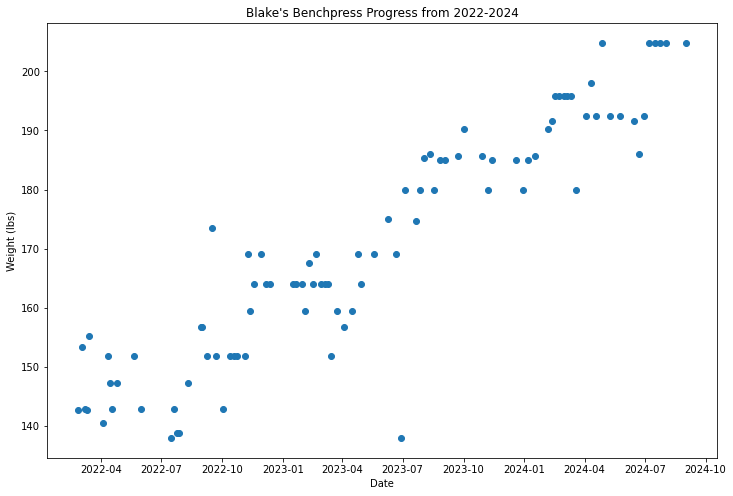

In [362]:
plt.figure(figsize=(12,8))
date = df[f'Date'][df[f'Bench_ORM'].between(df[f'Bench_ORM'].quantile(.05), df[f'Bench_ORM'].quantile(.95))] 
ORM = df[f'Bench_ORM'][df[f'Bench_ORM'].between(df[f'Bench_ORM'].quantile(.05), df[f'Bench_ORM'].quantile(.95))] 
plt.scatter(date,ORM)
plt.ylabel("Weight (lbs)")
plt.xlabel("Date")
plt.title(f"Blake's Benchpress Progress from 2022-2024")

Text(0.5, 1.0, "Blake's Deadlift Progress from 2022-2024")

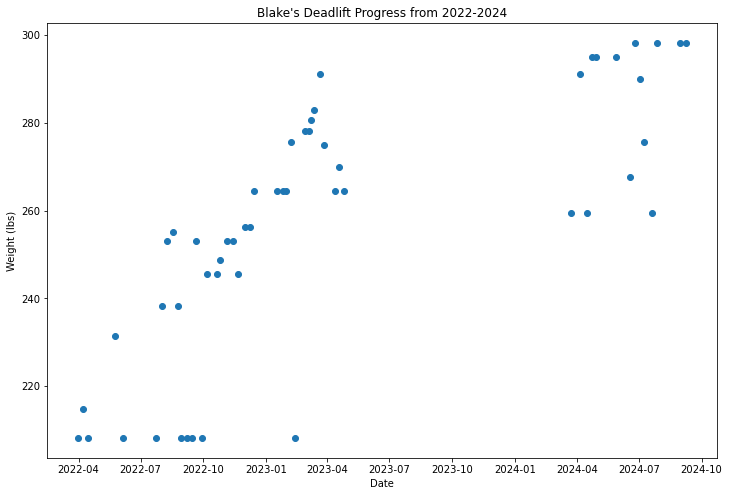

In [363]:
plt.figure(figsize=(12,8))

date = df[f'Date'][df[f'Dead_ORM'].between(df[f'Dead_ORM'].quantile(.05), df[f'Dead_ORM'].quantile(.95))] 
ORM = df[f'Dead_ORM'][df[f'Dead_ORM'].between(df[f'Dead_ORM'].quantile(.05), df[f'Dead_ORM'].quantile(.95))] 
plt.scatter(date,ORM)
plt.ylabel("Weight (lbs)")
plt.xlabel("Date")
plt.title(f"Blake's Deadlift Progress from 2022-2024")

Text(0.5, 1.0, "Blake's Squat Progress from 2022-2024")

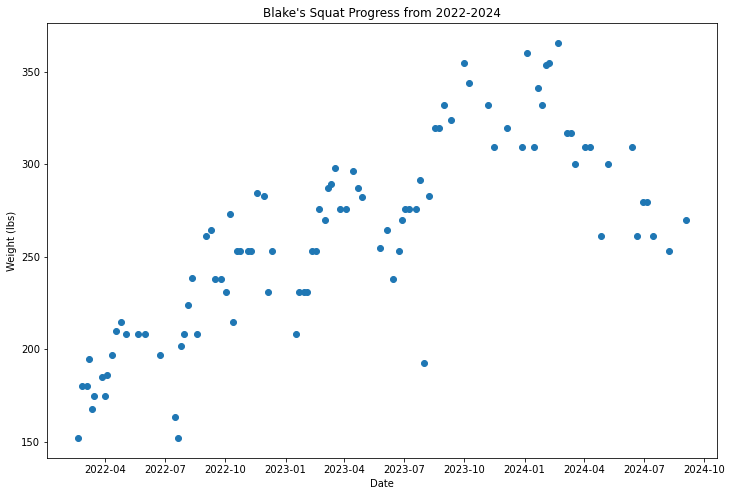

In [364]:
plt.figure(figsize=(12,8))
date = df[f'Date'][df[f'Squat_ORM'].between(df[f'Squat_ORM'].quantile(.02), df[f'Squat_ORM'].quantile(.97))] 
ORM = df[f'Squat_ORM'][df[f'Squat_ORM'].between(df[f'Squat_ORM'].quantile(.02), df[f'Squat_ORM'].quantile(.97))] 
plt.scatter(date,ORM)
plt.ylabel("Weight (lbs)")
plt.xlabel("Date")
#plt.scatter(df['Date'],df['Squat_ORM'])
plt.title(f"Blake's Squat Progress from 2022-2024")

Text(0.5, 1.0, "Blake's Skullcrusher Progress from 2022-2024")

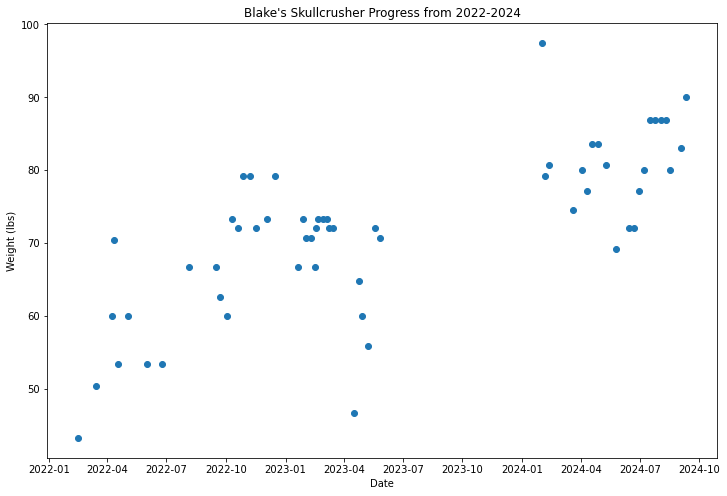

In [365]:
plt.figure(figsize=(12,8))
plt.ylabel("Weight (lbs)")
plt.xlabel("Date")
plt.scatter(df['Date'],df[f'Skull_ORM'])
plt.title(f"Blake's Skullcrusher Progress from 2022-2024")

Text(0.5, 1.0, "Blake's Overhead Press Progress from 2022-2024")

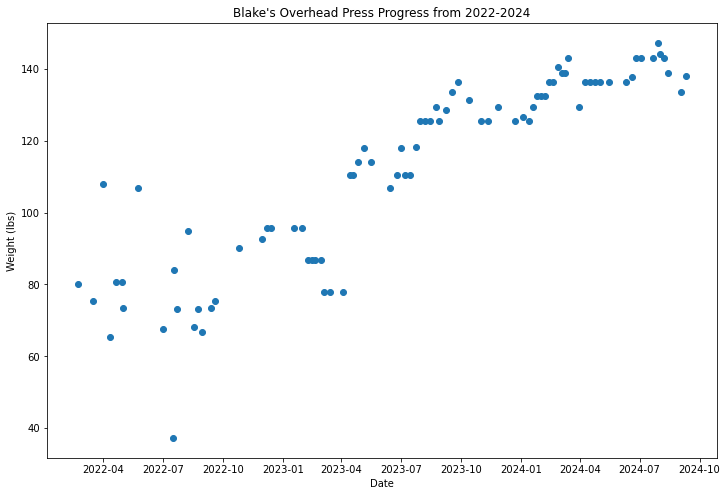

In [366]:
plt.figure(figsize=(12,8))
plt.ylabel("Weight (lbs)")
plt.xlabel("Date")
plt.scatter(df['Date'],df[f'Overhead press_ORM'])
plt.title(f"Blake's Overhead Press Progress from 2022-2024")

# Body Weight

In [370]:
with open(r"C:\Users\blake\OneDrive\Desktop\WorkoutData\iCloud Notes\Workouts\Weight log\Weight log-2023-08-15T16_56_48Z.txt", 'r',encoding="utf8") as f:
    content = f.readlines()
dates = []
weights = []
for i in content:
    ah = i.split(' - ')
    if len(ah) == 2:
        dates.append(pd.to_datetime(ah[0]))
        weights.append(int(''.join(filter(str.isdigit,ah[1]))[:3]))
weights = pd.DataFrame({"Dates":dates,"Weights":weights})
        

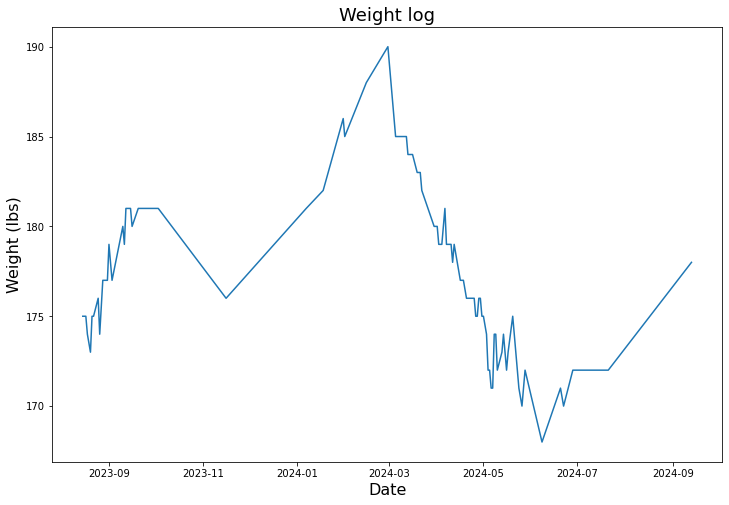

In [371]:
plt.figure(figsize=(12,8))
plt.xlabel("Date", fontsize=16)
plt.ylabel("Weight (lbs)", fontsize=16)
plt.title("Weight log", fontsize=18)
plt.plot(weights['Dates'],weights['Weights'])

# Analysis

In [372]:
### Isolate my workouts to when I was tracking my weight
during_log = df[df['Date'] > weights['Dates'][0]]

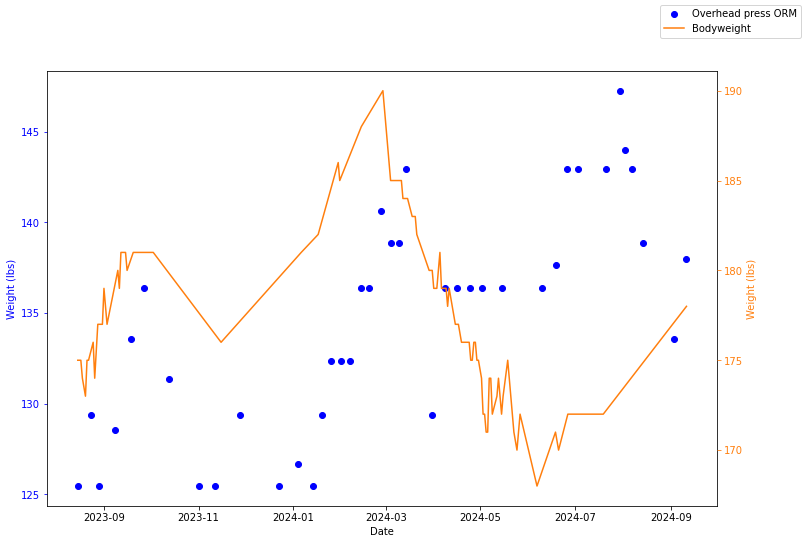

In [373]:
lift = "Overhead press"
fig=plt.figure(figsize=(12,8))



ax=fig.add_subplot(111, label="1")
ax2=fig.add_subplot(111, label="2", frame_on=False)


ax.scatter(during_log['Date'],during_log[f'{lift}_ORM'],color="Blue")
ax2.plot(weights['Dates'],weights['Weights'],color="C1")

ax.set_xlabel("Date", color="Black")
ax.set_ylabel("Weight (lbs)", color="Blue")
ax.tick_params(axis='x', colors="Black")
ax.tick_params(axis='y', colors="Blue")

ax2.xaxis.set_visible(False)
ax2.yaxis.tick_right()
ax2.set_ylabel('Weight (lbs)', color="C1")       
ax2.yaxis.set_label_position('right') 
ax2.tick_params(axis='y', colors="C1")
fig.legend([f'{lift} ORM','Bodyweight'])


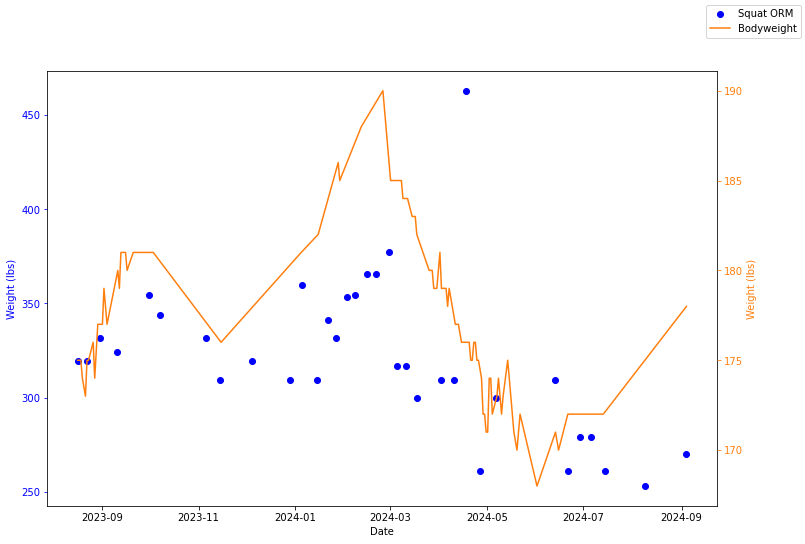

In [374]:
lift = "Squat"
fig=plt.figure(figsize=(12,8))



ax=fig.add_subplot(111, label="1")
ax2=fig.add_subplot(111, label="2", frame_on=False)


ax.scatter(during_log['Date'],during_log[f'{lift}_ORM'],color="Blue")
ax2.plot(weights['Dates'],weights['Weights'],color="C1")

ax.set_xlabel("Date", color="Black")
ax.set_ylabel("Weight (lbs)", color="Blue")
ax.tick_params(axis='x', colors="Black")
ax.tick_params(axis='y', colors="Blue")

ax2.xaxis.set_visible(False)
ax2.yaxis.tick_right()
ax2.set_ylabel('Weight (lbs)', color="C1")       
ax2.yaxis.set_label_position('right') 
ax2.tick_params(axis='y', colors="C1")
fig.legend([f'{lift} ORM','Bodyweight'])


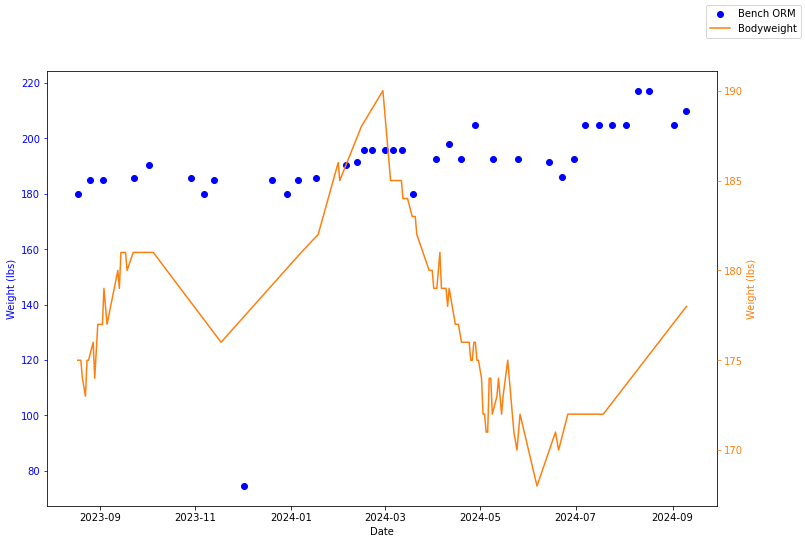

In [375]:
lift = "Bench"
fig=plt.figure(figsize=(12,8))



ax=fig.add_subplot(111, label="1")
ax2=fig.add_subplot(111, label="2", frame_on=False)


ax.scatter(during_log['Date'],during_log[f'{lift}_ORM'],color="Blue")
ax2.plot(weights['Dates'],weights['Weights'],color="C1")

ax.set_xlabel("Date", color="Black")
ax.set_ylabel("Weight (lbs)", color="Blue")
ax.tick_params(axis='x', colors="Black")
ax.tick_params(axis='y', colors="Blue")

ax2.xaxis.set_visible(False)
ax2.yaxis.tick_right()
ax2.set_ylabel('Weight (lbs)', color="C1")       
ax2.yaxis.set_label_position('right') 
ax2.tick_params(axis='y', colors="C1")
fig.legend([f'{lift} ORM','Bodyweight'])


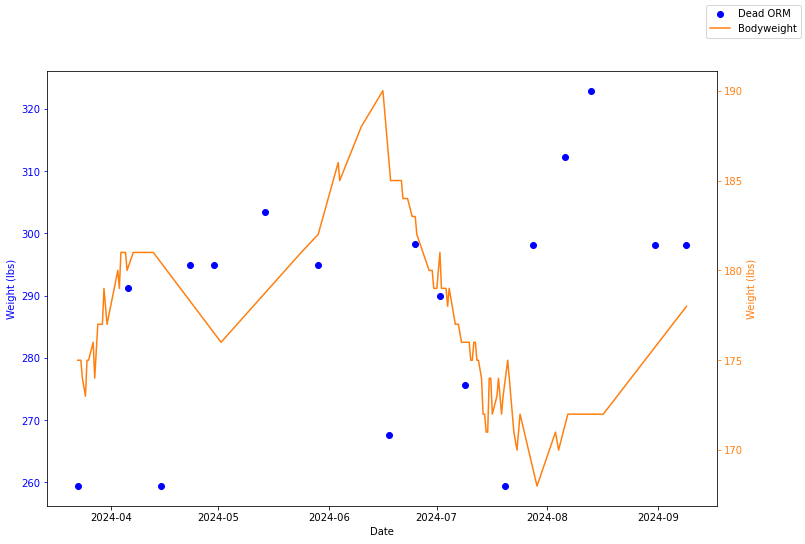

In [376]:
lift = "Dead"
fig=plt.figure(figsize=(12,8))



ax=fig.add_subplot(111, label="1")
ax2=fig.add_subplot(111, label="2", frame_on=False)


ax.scatter(during_log['Date'],during_log[f'{lift}_ORM'],color="Blue")
ax2.plot(weights['Dates'],weights['Weights'],color="C1")

ax.set_xlabel("Date", color="Black")
ax.set_ylabel("Weight (lbs)", color="Blue")
ax.tick_params(axis='x', colors="Black")
ax.tick_params(axis='y', colors="Blue")

ax2.xaxis.set_visible(False)
ax2.yaxis.tick_right()
ax2.set_ylabel('Weight (lbs)', color="C1")       
ax2.yaxis.set_label_position('right') 
ax2.tick_params(axis='y', colors="C1")
fig.legend([f'{lift} ORM','Bodyweight'])
